## Mall Customers' Segmentation using Partitional and Hierarchical Clustering

In [45]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import seaborn as sns

from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#### Dataset for this project: https://drive.google.com/file/d/19BOhwz52NUY3dg8XErVYglctpr5sjTy4/view

In [2]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#Check for missing values 
df.isnull().sum()

CustomerID        0
Gender            0
Age               0
Annual_income     0
Spending_score    0
dtype: int64

Female    112
Male       88
Name: Gender, dtype: int64


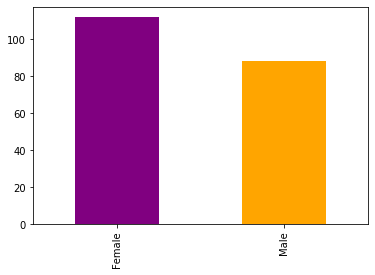

In [4]:
class_values = df['Gender'].value_counts()
print(class_values)
class_values.plot.bar(x = class_values[0], y = class_values[1], color=['purple', 'orange'])

There's a slight imbalance of data, but not a huge bias that we need to under or over sample.

Text(0, 0.5, 'Income (1000s)')

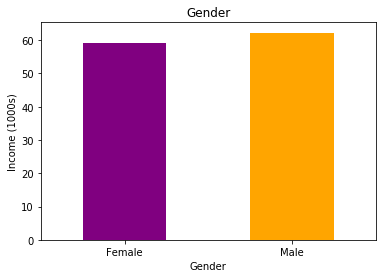

In [5]:
mean_val_income = df.groupby('Gender').Annual_income.mean().plot(kind='bar', color=['purple', 'orange'])
mean_val_income.set_xticklabels(labels=['Female', 'Male'], rotation=0)
mean_val_income.set_title('Gender')
mean_val_income.set_ylabel('Income (1000s)')


Males and Females have the same average income.

In [7]:
print(df.Age.describe())
print(df.Annual_income.describe())
print(df.Spending_score.describe())

count    200.000000
mean      38.850000
std       13.969007
min       18.000000
25%       28.750000
50%       36.000000
75%       49.000000
max       70.000000
Name: Age, dtype: float64
count    200.000000
mean      60.560000
std       26.264721
min       15.000000
25%       41.500000
50%       61.500000
75%       78.000000
max      137.000000
Name: Annual_income, dtype: float64
count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Spending_score, dtype: float64


The descriptive analytics show that the three variables - Age, annual income and spending score are almost at the same scale (since income is represented in 1000s).

{'whiskers': [<matplotlib.lines.Line2D at 0x1a2516e290>,
 'caps': [<matplotlib.lines.Line2D at 0x1a238cfc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a238d34d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a25dfc690>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a25dfcb90>],
 'means': []}

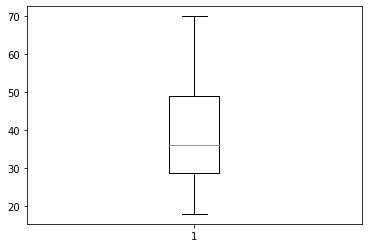

In [98]:
plt.boxplot(df['Age'])

There are no outliers in the Age column, so I will leave it as it is.

{'whiskers': [<matplotlib.lines.Line2D at 0x1a25624890>,
 'caps': [<matplotlib.lines.Line2D at 0x1a25cfee90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a25624850>],
 'medians': [<matplotlib.lines.Line2D at 0x1a25cfaa10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a25cfaf10>],
 'means': []}

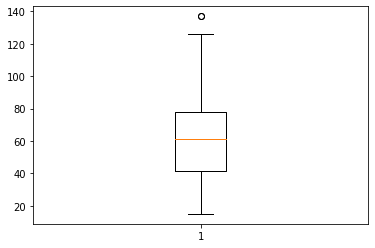

In [99]:
plt.boxplot(df['Annual_income'])

There is one outlier in the Annual income column, but as it still appears to be a reasonable income value, I will leave it in the dataset.

## Dataset Preprocessing

The dataset needs to undergo the following pre-processing steps:
1. The 'Gender' column needs to be converted into dummy variables, so the observations are in a formal able to be understood by the clustering alogorithm. In other words, all categorical data needs to be converted to binary format.
2. All values need to be normalised, so that one feature is not given more importance or weightage while calculating the distance to the cluster centroid.

First I will normalise the values in the 'Age', 'Annual_income', 'Spending_score' columns, and drop the 'CustomerID' column for now.

In [8]:
df_norm = pd.DataFrame(df)

def normalise(col_name):
    df_norm[col_name] = (df_norm[col_name] - df_norm[col_name].mean()) /\
    (df_norm[col_name].max() - df_norm[col_name].min())
    
normalise('Age')
normalise('Annual_income')
normalise('Spending_score')

df_norm = df_norm.drop(columns=['CustomerID'])
df_norm.head()

,Gender,Age,Annual_income,Spending_score
0,Male,-0.381731,-0.373443,-0.114286
1,Male,-0.343269,-0.373443,0.314286
2,Female,-0.362500,-0.365246,-0.451020
3,Female,-0.304808,-0.365246,0.273469
4,Female,-0.150962,-0.357049,-0.104082


In [9]:
#df_norm = pd.DataFrame(df)

#Convert Gender column to categorical
def convert_to_categorical(col_name):
    df_norm[col_name] = df[col_name].astype('category')

convert_to_categorical('Gender')

new_cols = pd.get_dummies(df_norm['Gender'],prefix='gender')
df_norm = pd.concat([df_norm,new_cols.round().astype(int)], axis=1)
df_norm = df_norm.drop(columns=['Gender'])
df_norm.head()

,Age,Annual_income,Spending_score,gender_Female,gender_Male
0,-0.381731,-0.373443,-0.114286,0,1
1,-0.343269,-0.373443,0.314286,0,1
2,-0.362500,-0.365246,-0.451020,1,0
3,-0.304808,-0.365246,0.273469,1,0
4,-0.150962,-0.357049,-0.104082,1,0


## K-means Clustering

Now that the data is ready for clustering, I will plot the elbow curve to determine the optimal number of clusters.

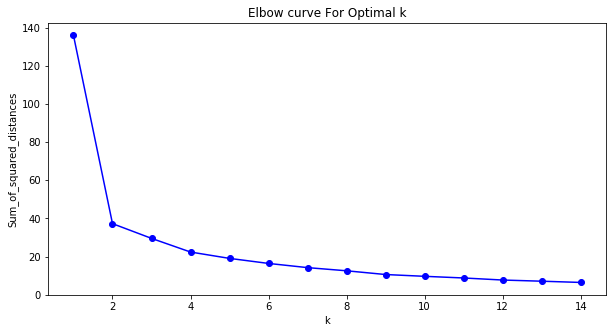

In [10]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(K, Sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow curve For Optimal k')
plt.show()

From the elbow curve above, the most optimal number of clusters would be 4, for this given dataset. Adding more clusters after this does not decrease the distances to the centroid significantly, and at this point we are most likely to have the optimal cluster centroids.

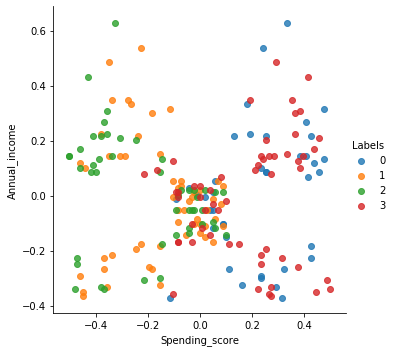

In [90]:
X = np.array(df_norm).astype(float)

labels = KMeans(4, n_init=10, random_state=1).fit_predict(X)
X = pd.DataFrame(X)
X['labels'] = labels
X.columns = ['Age', 'Annual_income', 'Spending_score', 'gender_Female', 'gender_Male', 'Labels']
X.head()
facet = sns.lmplot(data=X, x='Spending_score', y='Annual_income', hue='Labels', 
                   fit_reg=False, legend=True, legend_out=True)


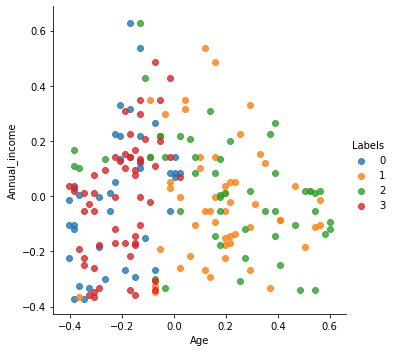

In [91]:
facet = sns.lmplot(data=X, x='Age', y='Annual_income', hue='Labels', 
                   fit_reg=False, legend=True, legend_out=True)

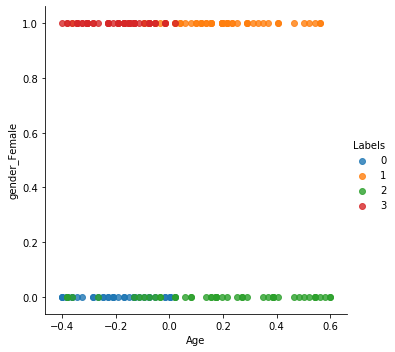

In [92]:
facet = sns.lmplot(data=X, x='Age', y='gender_Female', hue='Labels', 
                   fit_reg=False, legend=True, legend_out=True)

## Conclusions

- Females that have a larger spending score are generally on the younger side of the age scale (below average age in the data), and the same is observed for males.
- Males with a lower spending score however have a larger age range, compared to those that have a higher spending score.
- Females with a lower spending score are either around the average age or higher.
- Males with a higher annual income have a lower spending score, however the same is not observed for females. In the case of females, both groups that have a high and low spending scores have a range of incomes from low to high. Therefore, if a male has a higher annual income, there is no point targeting ads etc at them because they are less likely to spend.
- Males with a higher spending score however have a range of incomes.
- Males with an average spending score have low-average annual income.
- Older males tend to have a lesser annual income (and an average spending score!), but the same is not true for females.


## Why normalisation is important

### K-means clustering without normalisation

Below are scatterplots that visualise the same thing as the above scatterplots. While at first glance, it seems to be better to use non-normalised data (clusters are more defined), when the 'Spending Score' vs 'Gender' cluster is plotted, the *normalised* dataset shows a clear difference between the spending scores of males and females which is not visible in the non-normalised dataset. This is because the non-normalised data has values that go up to 100, but Gender only take the values 0 and 1. There is a huge difference in values, and K-means is tending to not give Gender enough importance durnig clustering.

K-means clustering is very sensitive to the scale of values in calculating the distances - it is always better to normalise the data so it is in the same scale. If I was to remove Gender completely from the clustering, the K-means would produce more distinct clusters as well. However, it seems that inclusion of the Gender variables is what is causing overlapping of clusters.

In [84]:
data = pd.DataFrame(df)

#Convert Gender column to categorical
def convert_to_categorical(col_name):
    data[col_name] = df[col_name].astype('category')

convert_to_categorical('Gender')

new_cols = pd.get_dummies(data['Gender'],prefix='gender')
data = pd.concat([data,new_cols.round().astype(int)], axis=1)
data = data.drop(columns=['Gender', 'CustomerID'])
data.head()

,Age,Annual_income,Spending_score,gender_Female,gender_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


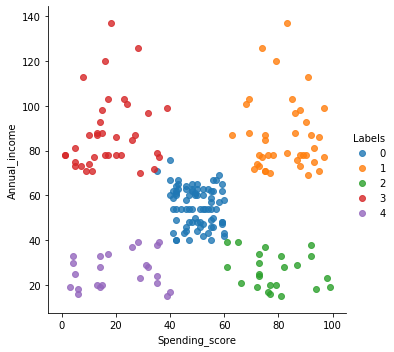

In [87]:
# scatter plot without normalisation

X = np.array(data).astype(float)

labels = KMeans(5, random_state=1).fit_predict(X)
X = pd.DataFrame(X)
X['labels'] = labels
X.columns = ['Age', 'Annual_income', 'Spending_score', 'gender_Female', 'gender_Male', 'Labels']
X.head()
facet = sns.lmplot(data=X, x='Spending_score', y='Annual_income', hue='Labels', 
                   fit_reg=False, legend=True, legend_out=True)


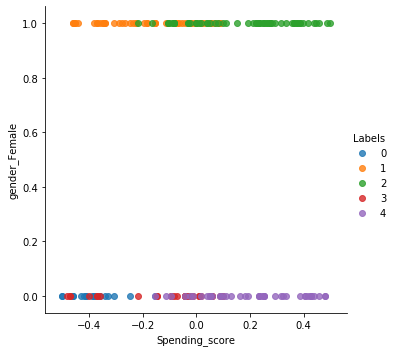

In [16]:
facet = sns.lmplot(data=X, x='Spending_score', y='gender_Female', hue='Labels', 
                   fit_reg=False, legend=True, legend_out=True)

### K-means clustering without 'Gender' (normalised)

In [17]:
data_nogender = pd.DataFrame(df)

def normalise(col_name):
    data_nogender[col_name] = (data_nogender[col_name] - data_nogender[col_name].mean()) /\
    (data_nogender[col_name].max() - data_nogender[col_name].min())
    
normalise('Age')
normalise('Annual_income')
normalise('Spending_score')

In [18]:
data_nogender=data_nogender.drop(columns=['CustomerID', 'Gender'])

data_nogender.head()

,Age,Annual_income,Spending_score
0,-0.381731,-0.373443,-0.114286
1,-0.343269,-0.373443,0.314286
2,-0.362500,-0.365246,-0.451020
3,-0.304808,-0.365246,0.273469
4,-0.150962,-0.357049,-0.104082


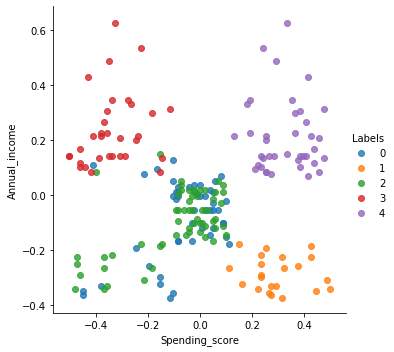

In [19]:
# scatter plot without normalisation

X = np.array(data_nogender).astype(float)

labels = KMeans(5, random_state=1).fit_predict(X)
X = pd.DataFrame(X)
X['labels'] = labels
X.columns = ['Age', 'Annual_income', 'Spending_score', 'Labels']
X.head()
facet = sns.lmplot(data=X, x='Spending_score', y='Annual_income', hue='Labels', 
                   fit_reg=False, legend=True, legend_out=True)



## Heirarchical Clustering

In [93]:
X = df_norm.values
X
X_crop = pd.DataFrame(df_norm)
X_crop = X_crop.drop(columns=['gender_Female', 'gender_Male'])
X_ctop = X_crop.values

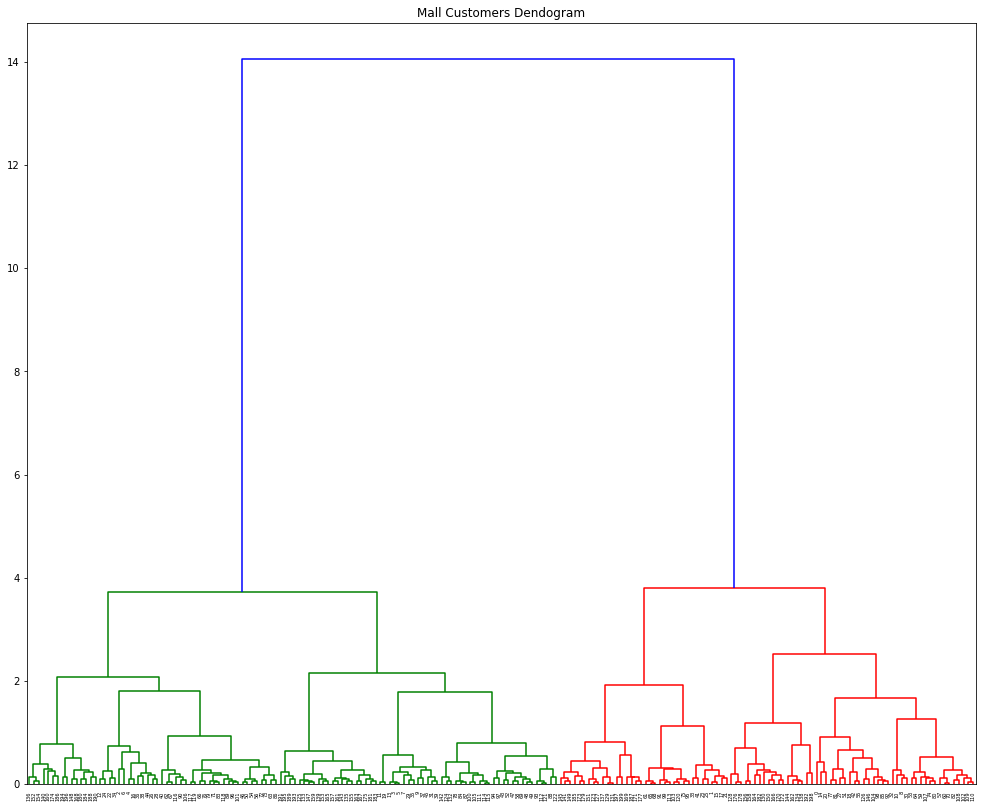

In [94]:
plt.figure(figsize=(17, 14))
plt.title("Mall Customers Dendogram")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [81]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([0, 2, 3, 1, 3, 1, 3, 1, 0, 1, 0, 1, 3, 1, 0, 2, 3, 2, 0, 1, 0, 2,
       3, 2, 3, 2, 3, 0, 3, 1, 0, 1, 0, 2, 3, 1, 3, 1, 3, 1, 3, 2, 0, 1,
       3, 1, 3, 1, 1, 1, 3, 0, 1, 0, 3, 0, 3, 0, 1, 0, 0, 2, 3, 3, 0, 2,
       3, 3, 2, 1, 0, 3, 3, 3, 0, 2, 3, 0, 1, 3, 0, 0, 0, 3, 1, 0, 3, 1,
       1, 3, 3, 2, 0, 1, 1, 2, 3, 1, 0, 2, 1, 3, 0, 2, 0, 1, 3, 0, 0, 0,
       0, 1, 1, 2, 1, 1, 3, 3, 3, 3, 2, 1, 1, 2, 1, 1, 0, 2, 0, 2, 0, 2,
       1, 1, 0, 1, 3, 2, 0, 1, 3, 2, 1, 1, 0, 2, 0, 1, 3, 2, 0, 2, 3, 1,
       3, 1, 0, 1, 0, 1, 3, 1, 0, 1, 0, 1, 0, 1, 3, 2, 0, 2, 0, 2, 3, 1,
       0, 2, 0, 2, 3, 1, 0, 1, 3, 2, 3, 2, 3, 1, 3, 1, 0, 1, 3, 1, 3, 2,
       0, 2])

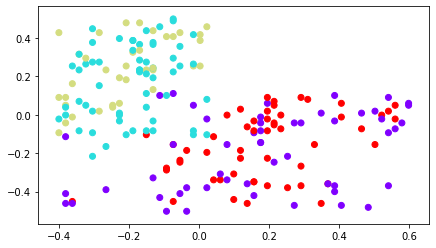

In [83]:
plt.figure(figsize=(7, 4))
# Plot Age vs spending score
plt.scatter(X[:,0],X[:,2], c=cluster.labels_, cmap='rainbow')

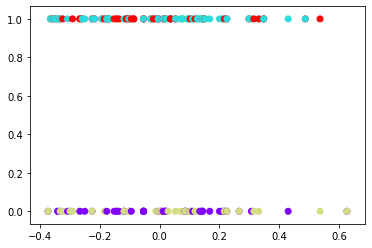

In [60]:
# plot Annual_income vs gender_Female
plt.scatter(X[:,1],X[:,3], c=cluster.labels_, cmap='rainbow')

Male: Purple and Lime Green
Female: Cyan and Red.

Both Genders: Low age = high spending score. High age = low spending score. Some younger men have lower spending scores.

As seen from the clusters, the same conclusions can be drawn from AgglomerativeClustering (Hierarchical Clustering) as K-means clustering (Partitional Clustering.

### Hierarchical Clustering without Gender

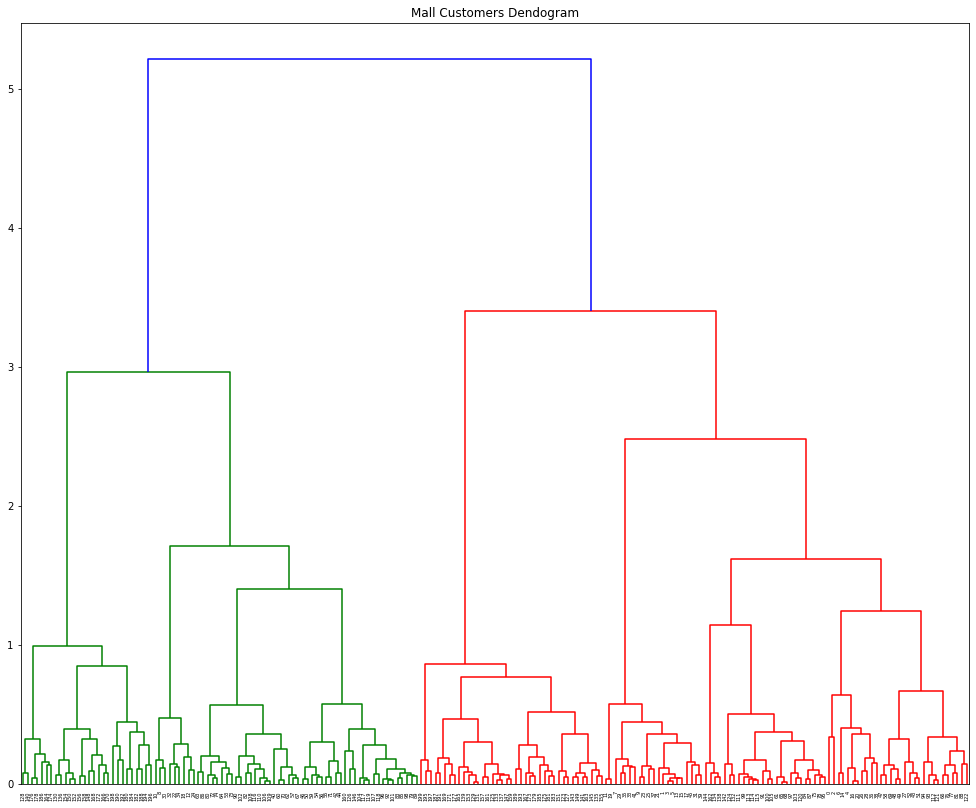

In [95]:
plt.figure(figsize=(17, 14))
plt.title("Mall Customers Dendogram")
dend = shc.dendrogram(shc.linkage(X_ctop, method='ward'))

From the dendogram above, the ideal number of clusters is 4.

In [96]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_ctop)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 1, 2, 3, 2, 3, 2,
       0, 2, 0, 2, 3, 2, 0, 2, 3, 2, 0, 2, 0, 2, 1, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 1, 2, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2])

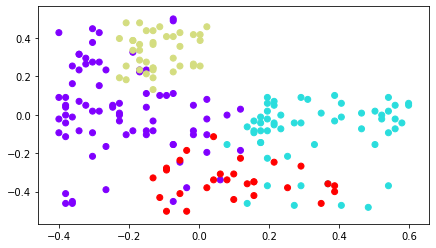

In [97]:
plt.figure(figsize=(7, 4))
# Plot Age vs spending score
plt.scatter(X_ctop[:,0],X_ctop[:,2], c=cluster.labels_, cmap='rainbow')